<a href="https://colab.research.google.com/github/idribeir0/sao-paulo-election-debate-comments/blob/main/debate_sp_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
os.environ["YOUTUBE_API_KEY"] = "sua_chave_api"

In [4]:
from googleapiclient.discovery import build
import os

importando bibliotecas e conectando com a chave da API

In [12]:
api_key = os.getenv("YOUTUBE_API_KEY")
youtube = build('youtube', 'v3', developerKey=api_key)

função para buscar comentários

In [15]:
def get_comments(video_id, max_comments=100):
  results = youtube.commentThreads().list(
      part="snippet",
      videoId=video_id,
      maxResults=max_comments,
      textFormat="plainText"
  ).execute()

  comments = []

  for item in results['items']:
    comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
    comments.append(comment)

  return comments

testando a função com o id do vídeo escolhido (nesse caso, o do debate para prefeito de SP na tv gazeta)

In [16]:
video_id = "8_13HMgZGiM"
comments = get_comments(video_id, max_comments=100)

print(comments[:5])

['Foi uma GaZorra total rs.', 'Tem que ser muito otário pra votar no Marçal', 'Como alguém consegue se manter sério com um debate desse 😂', 'Vote 28', 'Tenho pena do eleitor de SP, ter que sair de casa para votar em candidatos tão mal preparadas e fico admirado de ver as promessas de um candidato tão cara de pau como esse Pablo Marçal!']


fazendo a função que limpa os comentarios

In [26]:
import re
from unidecode import unidecode


def clean_comment(text):
  text = re.sub(r"http\S+", "", text)
  text = re.sub(r"[^\w\s.,?!]", "", text)
  text = unidecode(text)
  text = text.lower()
  return text

testando a função

In [27]:
clean_comments = [clean_comment(comment) for comment in comments]

print(clean_comments[:5])

['foi uma gazorra total rs.', 'tem que ser muito otario pra votar no marcal', 'como alguem consegue se manter serio com um debate desse ', 'vote 28', 'tenho pena do eleitor de sp, ter que sair de casa para votar em candidatos tao mal preparadas e fico admirado de ver as promessas de um candidato tao cara de pau como esse pablo marcal!']


criando lista de palavras positivas e negativas

In [56]:
positive_words = [
    "fantástica", "ótimo", "excelente", "maravilhoso", "incrível", "bom", "melhor", "apoiar", "feliz", "grande",
    "forte", "inteligente", "sensacional", "brilhante", "gostei", "impressionante", "honesto", "justo"
]
negative_words = [
    "imbecil", "palhaço", "horrível", "péssimo", "lixo", "ruim", "mentiroso", "fraude", "burro", "vergonhoso",
    "ridículo", "lamentável", "insuportável", "idiota", "mentira", "corrupto", "nojento", "sujo"
]


criando a funcao que analisa o sentimento de cada comentario com base na polaridade

In [57]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
  text_lower = text.lower()

  for word in positive_words:
        if word in text_lower:
            return "Positivo"

  scores = analyzer.polarity_scores(text)

  if scores['compound'] >= 0.02:
    return "Positivo"
  elif scores['compound'] <=0.02:
    return "Negativo"
  else: return "Neutro"

aplicando a nalise de sentimentos nos comentarios

In [58]:
vader_sentiments = [get_vader_sentiment(comment) for comment in clean_comments]

print(vader_sentiments[:5])

['Negativo', 'Negativo', 'Negativo', 'Negativo', 'Negativo']


contando a quantidade de cada tipo de sentimento

In [59]:
from collections import Counter

sentiment_counts = Counter(vader_sentiments)

print(sentiment_counts)

Counter({'Negativo': 92, 'Positivo': 8})


visualizando a distribuicao com um grafico de barras

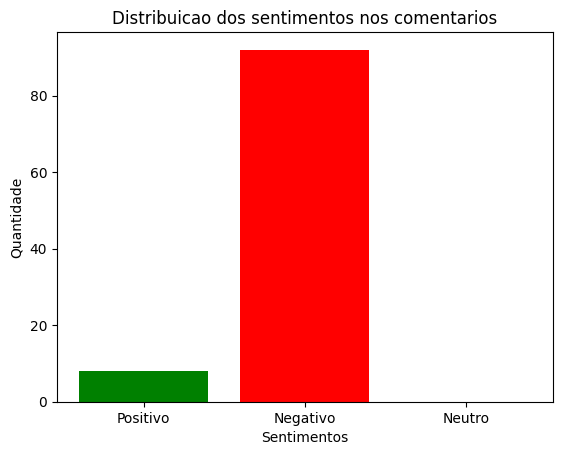

In [60]:
import matplotlib.pyplot as plt

sentiment_labels = ['Positivo', 'Negativo', 'Neutro']
sentiment_counts_ordered = [sentiment_counts.get('Positivo', 0), sentiment_counts.get('Negativo', 0), sentiment_counts.get('Neutro', 0)]

plt.bar(sentiment_labels, sentiment_counts_ordered, color=['green', 'red', 'gray'])
plt.title("Distribuicao dos sentimentos nos comentarios")
plt.xlabel("Sentimentos")
plt.ylabel("Quantidade")
plt.show()

criando a funcao de nuvem de palavras

In [61]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(text, title):
  wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.title(title, size=15)
  plt.axis("off")
  plt.show()

gerando a nuvem de palavras para comentarios positivos

Nuvem de Palavras - Comentários Positivos


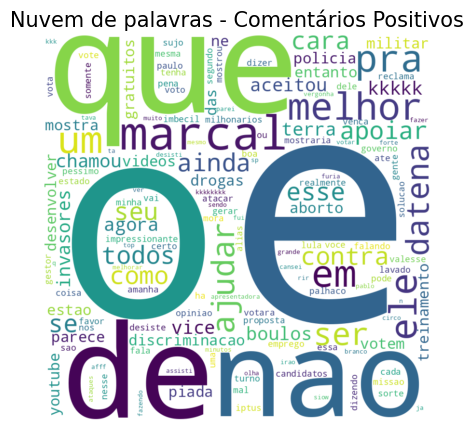

In [63]:
positive_comments = " ".join([comment for comment in clean_comments if get_vader_sentiment(comment) == "Positivo"])
print("Nuvem de Palavras - Comentários Positivos")
plot_wordcloud(positive_comments, "Nuvem de palavras - Comentários Positivos")

gerando a nuvem de palavras para comentarios negativos

Nuvem de Palavras - Comentários Negativos


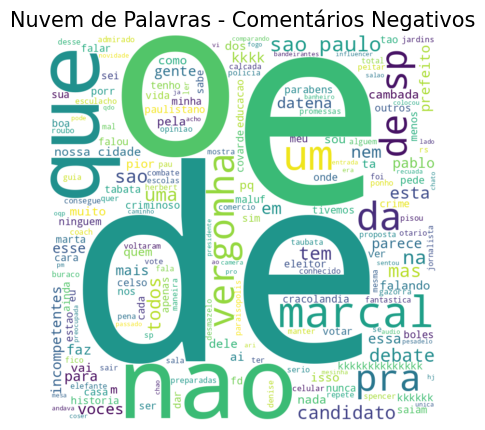

In [64]:
negative_comments = " ".join([comment for comment in clean_comments if get_vader_sentiment(comment) == "Negativo"])
print("Nuvem de Palavras - Comentários Negativos")
plot_wordcloud(negative_comments, "Nuvem de Palavras - Comentários Negativos")

funcao para pegar os scores de vader sem classificar e aplicar o vader para todos os comentarios

In [67]:
def get_vader_score(text):
    text_lower = text.lower()

    for word in negative_words:
        if word in text_lower:
            return -1.0
    for word in positive_words:
        if word in text_lower:
            return 1.0

    scores = analyzer.polarity_scores(text)
    return scores['compound']

encontrando os 5 comentarios mais positivos

In [68]:
comments_with_scores = [(comment, get_vader_score(comment)) for comment in clean_comments]

most_positive_comments = sorted(comments_with_scores, key=lambda x: x[1], reverse=True)[:5]
print("Comentarios mais positivos:")
for comment, score in most_positive_comments:
  print(f"Comentário: {comment} | Score: {score}")

Comentarios mais positivos:
Comentário: datena chamou boulos pra ser vice kkkkk, ele nao aceitou agora que ajudar os invasores de terra, apoiar a discriminacao das drogas, e apoiar o aborto e ainda e contra a policia militar... parece piada ne. votem no marcal ele mostra como ajudar a se desenvolver. no entanto todos os videos de treinamento do marcal estao gratuitos no youtube. | Score: 1.0
Comentário: cada um mostrou o seu melhor pra esse estado venca o melhor boa sorte a todos e que nao tenha segundo turno vote certo gente o  seu voto e a solucao  | Score: 1.0
Comentário: como essa apresentadora ta sendo forte de nao rir kkkkkkkk | Score: 1.0
Comentário: e um grande circo afff! cansei. 2 minutos q assisti ja desisti. so ataques de furia n irao melhorar sp. fui... | Score: 1.0
Comentário: vergonha mesmo. olha, melhor votar em branco. | Score: 1.0


encontrando os 5 comentarios mais negativos

In [69]:
negative_comments = [comment for comment in clean_comments if get_vader_sentiment(comment) == "Negativo"]
print(f"Total de comentários negativos: {len(negative_comments)}")
for comment in negative_comments[:10]:
  print(f"Comentário: {comment}")

Total de comentários negativos: 92
Comentário: foi uma gazorra total rs.
Comentário: tem que ser muito otario pra votar no marcal
Comentário: como alguem consegue se manter serio com um debate desse 
Comentário: vote 28
Comentário: tenho pena do eleitor de sp, ter que sair de casa para votar em candidatos tao mal preparadas e fico admirado de ver as promessas de um candidato tao cara de pau como esse pablo marcal!
Comentário: 3100 da cracolandia voltaram para suas cidades da mesma maneira
Comentário: que jornalista fantastica essa denise
Comentário: marcal, nunca pisou em paraisopolis! nao so tem guia, calcada, comercio e escolas... herbert spencer nao e coach , e gente. pra esse nem ponho na minha opiniao pq nem sabe ler. quer com esculacho?
Comentário: taubata, nos jardins nao tem buraco... 
e roubo de celular e falar de proposta? elefante na sala...
Comentário: datena e o mais covarde dos covardes. sabe onde o crime esta mas nao fala, pq so repete conhecido pra nao peitar crime e po